In [1]:
!pip install scikit-optimize
!pip install tensorflow_hub==0.12.0
!pip install tf-models-official==2.9.0

Looking in indexes: https://artifacts.dell.com/artifactory/api/pypi/python/simple
  Using cached https://artifacts.dell.com/artifactory/api/pypi/python/packages/packages/55/f6/2d9efbd86126c40fe0f8a47611a9e2480b493b6f0ce9751bdf0240cfa091/scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached https://artifacts.dell.com/artifactory/api/pypi/python/packages/packages/35/fd/78a3a11c7b9b11878ebbf4461a09cbc758bdfc1b45168972727f7334b09a/pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
Looking in indexes: https://artifacts.dell.com/artifactory/api/pypi/python/simple
  Using cached https://artifacts.dell.com/artifactory/api/pypi/python/packages/packages/29/32/899878aa65cae5429f30449cdda61224e3f4319e6a155027bc3af4c3f07b/tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
Looking in indexes: https://artifacts.dell.com/artifactory/api/pypi/python/simple
  Using cached https://artifacts.dell.com/artifactory/api/pypi/python/packages/packages/61/dd/5219d629cb5f107bb89a5f520fb61919b928d6501aad841a

In [2]:
from functools import partial
import pandas as pd
import seaborn as sns
import math
import numpy as np

from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray
from skopt import gp_minimize, Optimizer, space

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc
from itertools import cycle
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

2023-02-20 19:08:08.188137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell/.local/lib:/opt/microsoft/jdbc:/opt/oracle/odbc:/opt/oracle/jdbc11:/usr/share/java/:/opt/teradata/jdbc:/opt/cloudera/hiveodbc/lib/64/:/opt/cloudera/hivejdbc/:/opt/EXASOL_JDBC-7.1.10
2023-02-20 19:08:08.188185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('adult-income.csv')
df.head(3)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
columns = [column for column in df.columns if df[column].dtype == 'object']
columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country',
 'income']

In [6]:
for column in columns:
    df[column] = df[column].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


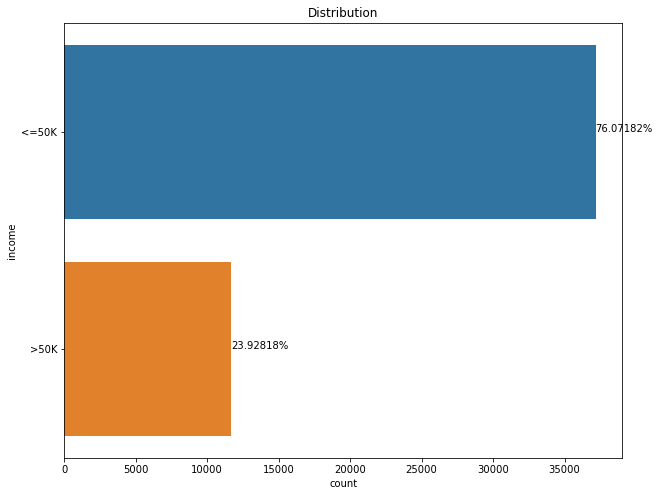

In [7]:
def value_count(df, col_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10,8))
    ax = sns.countplot(y = col_name, data=df, orient = 'v')

    plt.title('Distribution')

    total = len(df[col_name])
    for p in ax.patches:

        percentage = '{:.5f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()
    
value_count(df, "income")

In [8]:
target = "income"
cat_variables = [var for var in df.columns if df[var].dtype == 'category']
cat_vars = [s for s in cat_variables if s != target]
print('cat_vars:', cat_vars)
num_variables = [var for var in df.columns if df[var].dtype != 'category']
num_vars = [s for s in num_variables if s != target]
print('num_vars:', num_vars)
labels = num_vars + cat_vars
print('Labels:', labels)

cat_vars: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
num_vars: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Labels: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [9]:
def splitting(data, labels, target, split_ratio):
    
    X = data[labels]
    y = data[target]
    classes = np.unique(y) # Unique values for classes
    
    global num_classes
    
    if len(classes) == 2:
        num_classes = 1 # For binary
    else:
        num_classes = len(classes) # For multiclass

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = split_ratio, random_state = 101)
    
    lb = LabelBinarizer(neg_label = 0, pos_label=1, sparse_output = False)
    y_train = lb.fit_transform(y_train)
    y_test = lb.transform(y_test)
    
    col_names = X_train.columns

    return X_train, X_test, y_train, y_test, classes, lb, col_names

In [11]:
def optimizer(params, param_names):
    
    global X_train, X_test, y_train, y_test, classes, lb, col_names, input_dim, X_train_preprocessed, preprocess_pipeline, optimizer
    X_train, X_test, y_train, y_test, classes, lb, col_names = splitting(df, labels, target, split_ratio = 0.3)
            
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocess_pipeline = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_vars),
            ('cat', categorical_transformer, cat_vars)])
    
    X_train_preprocessed = preprocess_pipeline.fit_transform(X_train)
    input_dim = X_train_preprocessed.shape[1]
    joblib.dump(preprocess_pipeline, 'preprocess_pipeline.pkl')

    params = dict(zip(param_names, params))
    def build_classifier_(): # learning_rate=0.05, upperlayers=2, upperlayersdense=128, lowerlayers=1, lowerlayersdense=64, dropout_rate=0.2

        # Model Building
        opt = keras.optimizers.Adam(params["learning_rate"])
        model = Sequential() 
        model.add(Dense(256, activation='relu', input_dim = input_dim))
        model.add(Dropout(params["dropout_rate"]))
        model.add(BatchNormalization())

        for i in range(1, params["upperlayers"]):
            model.add(Dense(params["upperlayersdense"], activation='relu'))
            model.add(Dropout(params["dropout_rate"]))
            model.add(BatchNormalization())

        for i in range(1, params["lowerlayers"]):
            model.add(Dense(params["lowerlayersdense"], activation='relu'))
            model.add(Dropout(params["dropout_rate"]))
            model.add(BatchNormalization())

        model.add(Dense(units = num_classes, activation='sigmoid'))
        model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return model
    
    classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)
    
    accuracies =  cross_val_score(estimator=classifier, X = X_train_preprocessed.toarray(), 
                                  y = y_train.ravel(), cv = 5, n_jobs = -1, 
                                  verbose=0, fit_params={'callbacks': [EarlyStopping(monitor='loss', patience=3)]})
    
    print('accuracies :', accuracies)
    print('params:', params)
    print()
    
    return -1 * accuracies.mean()

In [12]:
param_names = ["upperlayers", "lowerlayers", "upperlayersdense", "lowerlayersdense", "learning_rate", "dropout_rate"]

param_space = [
    space.Integer(1, 3, name="upperlayers"),
    space.Integer(1, 2, name="lowerlayers"),
    space.Integer(128, 192, name="upperlayersdense"),
    space.Integer(64, 128, name="lowerlayersdense"),
    space.Real(0.005, 0.05, name="learning_rate"),
    space.Real(0.1, 0.5, name="dropout_rate")
]

In [13]:
optimization_func = partial(optimizer, param_names=param_names)

In [14]:
%%time

from tqdm import tqdm_notebook as tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

n_calls = 15 # Minimum 5 calls

result = gp_minimize(optimization_func,
                     dimensions=param_space,
                     n_calls=n_calls,
                     n_jobs=-1,
                     random_state=42,
                     n_random_starts=10,
                     verbose=True,
                     callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process Optimization")])


<timed exec>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Gaussian Process Optimization:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)
2023-02-20 19:08:12.945003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell/.local/lib:/opt/microsoft/jdbc:/opt/oracle/odbc:/opt/oracle/jdbc11:/usr/share/java/:/opt/teradata/jdbc:/opt/cloudera/hiveodbc/lib/64/:/opt/cloudera/hivejdbc/:/opt/EXASOL_JDBC-7.1.10
2023-02-20 19:08:12.945062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 19:08:12.981705: W tensorflow/stream_executor/platform/defa

accuracies : [0.85565954 0.83752561 0.85829192 0.85946184 0.84452248]
params: {'upperlayers': 3, 'lowerlayers': 1, 'upperlayersdense': 178, 'lowerlayersdense': 102, 'learning_rate': 0.02506247387841161, 'dropout_rate': 0.13998996632720118}

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 194.6036
Function value obtained: -0.8511
Current minimum: -0.8511
Iteration No: 2 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85522085 0.84001172 0.85682946 0.85887688 0.84861779]
params: {'upperlayers': 2, 'lowerlayers': 1, 'upperlayersdense': 137, 'lowerlayersdense': 106, 'learning_rate': 0.007538521056219513, 'dropout_rate': 0.38879950890673}

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 141.8526
Function value obtained: -0.8519
Current minimum: -0.8519
Iteration No: 3 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85375839 0.84732378 0.85580581 0.8547821  0.84978789]
params: {'upperlayers': 3, 'lowerlayers': 1, 'upperlayersdense': 192, 'lowerlayersdense': 104, 'learning_rate': 0.03252439222197265, 'dropout_rate': 0.10282652208788697}

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 159.4739
Function value obtained: -0.8523
Current minimum: -0.8523
Iteration No: 4 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85522085 0.84527642 0.85931557 0.84907866 0.84949541]
params: {'upperlayers': 1, 'lowerlayers': 2, 'upperlayersdense': 154, 'lowerlayersdense': 67, 'learning_rate': 0.048818998347865676, 'dropout_rate': 0.19310853617212173}

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 76.0362
Function value obtained: -0.8517
Current minimum: -0.8523
Iteration No: 5 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.8585844  0.82129276 0.85843813 0.86136299 0.83954948]
params: {'upperlayers': 1, 'lowerlayers': 2, 'upperlayersdense': 152, 'lowerlayersdense': 127, 'learning_rate': 0.026004330196159105, 'dropout_rate': 0.44397616269452833}

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 102.1109
Function value obtained: -0.8478
Current minimum: -0.8523
Iteration No: 6 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.86092424 0.843229   0.85492831 0.85990053 0.84700894]
params: {'upperlayers': 2, 'lowerlayers': 1, 'upperlayersdense': 129, 'lowerlayersdense': 124, 'learning_rate': 0.030347969803049275, 'dropout_rate': 0.2541666010159665}

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 84.3447
Function value obtained: -0.8532
Current minimum: -0.8532
Iteration No: 7 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85668325 0.84396023 0.84001172 0.85726821 0.8513968 ]
params: {'upperlayers': 1, 'lowerlayers': 1, 'upperlayersdense': 143, 'lowerlayersdense': 108, 'learning_rate': 0.03244984960021795, 'dropout_rate': 0.4332779646944659}

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 37.4241
Function value obtained: -0.8499
Current minimum: -0.8532
Iteration No: 8 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85741442 0.85083359 0.8547821  0.85346591 0.84978789]
params: {'upperlayers': 1, 'lowerlayers': 1, 'upperlayersdense': 140, 'lowerlayersdense': 112, 'learning_rate': 0.024132014352106018, 'dropout_rate': 0.18317666514727557}

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 70.9135
Function value obtained: -0.8533
Current minimum: -0.8533
Iteration No: 9 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.81558937 0.84790874 0.84995615 0.85507458 0.84247476]
params: {'upperlayers': 2, 'lowerlayers': 1, 'upperlayersdense': 182, 'lowerlayersdense': 93, 'learning_rate': 0.022781760620081658, 'dropout_rate': 0.47066354631751783}

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 85.7034
Function value obtained: -0.8422
Current minimum: -0.8533
Iteration No: 10 started. Evaluating function at random point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.84396023 0.8524422  0.8470313  0.85024863 0.84496123]
params: {'upperlayers': 2, 'lowerlayers': 1, 'upperlayersdense': 165, 'lowerlayersdense': 97, 'learning_rate': 0.048252741095720725, 'dropout_rate': 0.43781353947126067}

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 68.1418
Function value obtained: -0.8477
Current minimum: -0.8533
Iteration No: 11 started. Searching for the next optimal point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.8524422  0.84542263 0.85814565 0.84922493 0.84964168]
params: {'upperlayers': 2, 'lowerlayers': 2, 'upperlayersdense': 128, 'lowerlayersdense': 72, 'learning_rate': 0.005, 'dropout_rate': 0.1}

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 169.9217
Function value obtained: -0.8510
Current minimum: -0.8533
Iteration No: 12 started. Searching for the next optimal point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85653698 0.84937114 0.79760164 0.79643172 0.80912679]
params: {'upperlayers': 1, 'lowerlayers': 2, 'upperlayersdense': 128, 'lowerlayersdense': 105, 'learning_rate': 0.05, 'dropout_rate': 0.339506310785901}

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 87.1105
Function value obtained: -0.8218
Current minimum: -0.8533
Iteration No: 13 started. Searching for the next optimal point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85302722 0.84922493 0.84776253 0.83664817 0.83428407]
params: {'upperlayers': 1, 'lowerlayers': 1, 'upperlayersdense': 164, 'lowerlayersdense': 64, 'learning_rate': 0.04849886433072596, 'dropout_rate': 0.12067064487142899}

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 39.0851
Function value obtained: -0.8442
Current minimum: -0.8533
Iteration No: 14 started. Searching for the next optimal point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)


accuracies : [0.85214972 0.85010237 0.85843813 0.85463583 0.84686267]
params: {'upperlayers': 3, 'lowerlayers': 1, 'upperlayersdense': 128, 'lowerlayersdense': 116, 'learning_rate': 0.005, 'dropout_rate': 0.5}

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 155.8878
Function value obtained: -0.8524
Current minimum: -0.8533
Iteration No: 15 started. Searching for the next optimal point.


/tmp/ipykernel_129/1414430554.py:47: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier_, epochs=25, batch_size = 64, verbose=0)
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2023-02-20 19:34:37.510606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell/.local/lib:/opt/microsoft/jdbc:/opt/oracle/odbc:/opt/oracle/jdbc11:/usr/share/java/:/opt/teradata/jdbc:/opt/cloudera/hiveodbc/lib/64/:/opt/cloudera/hivejdbc/:/opt

accuracies : [0.85960805 0.84893245 0.84366775 0.85873061 0.84481496]
params: {'upperlayers': 3, 'lowerlayers': 2, 'upperlayersdense': 143, 'lowerlayersdense': 84, 'learning_rate': 0.011331266366517719, 'dropout_rate': 0.4896107647764284}

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 155.7071
Function value obtained: -0.8512
Current minimum: -0.8533
CPU times: user 11.3 s, sys: 7.37 s, total: 18.6 s
Wall time: 27min 8s


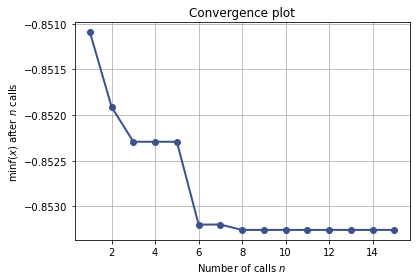

In [15]:
from skopt.plots import plot_convergence
plot_convergence(result);

In [16]:
tuned_param = dict(zip(param_names, result.x))
print(tuned_param)

{'upperlayers': 1, 'lowerlayers': 1, 'upperlayersdense': 140, 'lowerlayersdense': 112, 'learning_rate': 0.024132014352106018, 'dropout_rate': 0.18317666514727557}


In [26]:
def plot_loss(history):
    
    # print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

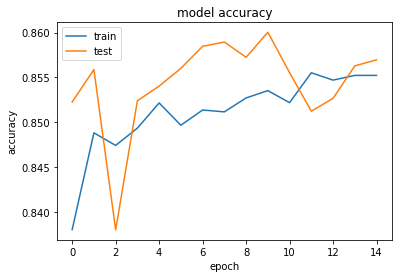

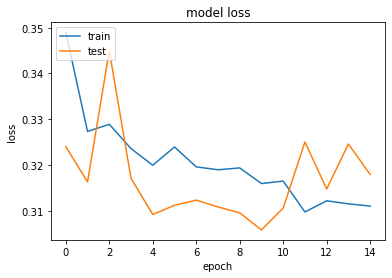

In [27]:
import matplotlib.pyplot as plt

model = Sequential() 

opt = keras.optimizers.Adam(learning_rate = tuned_param["learning_rate"])
    
model.add(Dense(256, activation='relu', input_dim = input_dim))
model.add(BatchNormalization())
model.add(Dropout(tuned_param["dropout_rate"]))

model.add(Dense(tuned_param["upperlayersdense"], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(tuned_param["dropout_rate"]))

model.add(Dense(tuned_param["lowerlayersdense"], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(tuned_param["dropout_rate"]))

# num_classes
model.add(Dense(units = 1, activation='sigmoid'))

model.compile(optimizer = opt, loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

history = model.fit(X_train_preprocessed.toarray(), y_train, epochs = 50, 
          validation_data = (preprocess_pipeline.transform(X_test).toarray(), y_test), 
          callbacks = EarlyStopping(monitor='loss', patience=3), batch_size = 64, verbose=0)

# summarize history for accuracy
plot_loss(history)